In [1]:
import re
import nltk
from bs4 import BeautifulSoup
import numpy as np
from urllib.request import urlopen
import string
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim import matutils

In [2]:
import pyLDAvis.gensim

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

### Case study - Tagging 20newsgroups

In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',remove=('footers'))#can filter footnotes here

In [5]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [6]:
len(newsgroups_train.data)

11314

In [7]:
print(newsgroups_train.data[3])

From: jgreen@amber (Joe Green)
Subject: Re: Weitek P9000 ?
Organization: Harris Computer Systems Division
Lines: 14
Distribution: world
NNTP-Posting-Host: amber.ssd.csd.harris.com
X-Newsreader: TIN [version 1.1 PL9]

Robert J.C. Kyanko (rob@rjck.UUCP) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > Anyone know about the Weitek P9000 graphics chip?
> As far as the low-level stuff goes, it looks pretty nice.  It's got this
> quadrilateral fill command that requires just the four points.

Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.



In [8]:
newsgroups_train.target

array([7, 4, 4, ..., 3, 1, 8])

In [9]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### Split with \n

In [10]:
type(newsgroups_train.data[3])

str

In [11]:
print(newsgroups_train.data[3].split('\n\n')[0])

From: jgreen@amber (Joe Green)
Subject: Re: Weitek P9000 ?
Organization: Harris Computer Systems Division
Lines: 14
Distribution: world
NNTP-Posting-Host: amber.ssd.csd.harris.com
X-Newsreader: TIN [version 1.1 PL9]


In [12]:
len(newsgroups_train.data[3].split('\n\n'))

3

In [13]:
newsgroups_train.data[3].split('\n\n')[1:len(newsgroups_train.data[3].split('\n\n'))]

["Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It's got this\n> quadrilateral fill command that requires just the four points.",
 "Do you have Weitek's address/phone number?  I'd like to get some information\nabout this chip.\n"]

In [14]:
news_no_heading = ['\n'.join(new.split('\n\n')[1:len(new.split('\n\n'))]) 
                   for new in newsgroups_train.data]

In [15]:
print(news_no_heading[3])

Robert J.C. Kyanko (rob@rjck.UUCP) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > Anyone know about the Weitek P9000 graphics chip?
> As far as the low-level stuff goes, it looks pretty nice.  It's got this
> quadrilateral fill command that requires just the four points.
Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.



### Remove too short news (at least 10 characters)

In [16]:
news_length = [len(news)for news in news_no_heading]
min(news_length),max(news_length)

(0, 74654)

In [17]:
first_len = sorted(news_length)[:500]

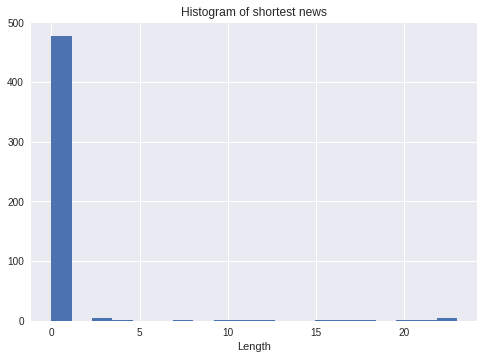

In [18]:
plt.hist(first_len,bins=20)
plt.title('Histogram of shortest news')
plt.xlabel('Length')
plt.show()

In [19]:
news_filtered = [news_no_heading[ind] for ind,val in enumerate(news_length) if val>10]

In [20]:
len(news_no_heading)

11314

In [21]:
len(news_filtered)

10827

In [22]:
news_target = [newsgroups_train.target[ind] for ind,val in enumerate(news_length) if val>10]

In [23]:
len(news_target)

10827

### Lower letters

In [24]:
news_lower_letter = [new.lower() for new in news_filtered]

In [25]:
print(news_lower_letter[3])

robert j.c. kyanko (rob@rjck.uucp) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > anyone know about the weitek p9000 graphics chip?
> as far as the low-level stuff goes, it looks pretty nice.  it's got this
> quadrilateral fill command that requires just the four points.
do you have weitek's address/phone number?  i'd like to get some information
about this chip.



### Tokenize - document segmentation

In [26]:
news_tokenized = [nltk.word_tokenize(new) for new in news_lower_letter]

In [27]:
len(news_tokenized[0])

106

### Remove punctuation

In [28]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
news_no_punct = [
    [token for token in new if token not in string.punctuation]
    for new in news_tokenized
]

In [30]:
len(news_no_punct[0])

91

### Removing stopwords

In [31]:
stopwords = nltk.corpus.stopwords.words('english')

In [32]:
news_no_stopwords = [
    [token for token in new if not token in stopwords]
    for new in news_no_punct
]

### Stemming - words normalization

In [33]:
stemmer = nltk.PorterStemmer()

In [34]:
news_stemmed = [
    [stemmer.stem(token) for token in new]
    for new in news_no_stopwords
]

### Merging into one text

In [35]:
news_cleaned = [' '.join(tokens) for tokens in news_stemmed]

### TF-IDF

In [36]:
tf_idf = TfidfVectorizer(min_df=2, max_df=0.7) 
# default pattern remove one letter long words

In [37]:
tf_idf.fit(news_cleaned)
dtm = tf_idf.transform(news_cleaned)
dtm

<10827x36021 sparse matrix of type '<class 'numpy.float64'>'
	with 972033 stored elements in Compressed Sparse Row format>

### Top words

In [38]:
def top_words(matrix,vectorizer,k):
    
    words = np.array(vectorizer.get_feature_names())
    top_words = []
    
    for art in range(matrix.shape[0]):

        words_counter =  matrix.getrow(art).toarray()[0]

        words_counter = np.argsort(words_counter)
        words_counter = words_counter[::-1]
        
        top_words_indices = words_counter[:k]
        top_document_words = words[top_words_indices]
        
        
        top_words.append(top_document_words) 
        
    return np.array(top_words)

In [39]:
top_words(dtm,tf_idf,5)[:15]

array([['car', 'door', '60s', 'tellm', 'bricklin'],
       ['poll', 'floppi', 'clock', 'upgrad', 'add'],
       ['180', 'powerbook', 'display', '160', 'machin'],
       ['weitek', 'iastate', '734340159', 'quadrilater', 'abraxis'],
       ['error', 'warn', 'std', 'bug', 'tom'],
       ['weapon', 'destruct', 'stratus', 'mass', 'cdt'],
       ['thank', 'debra', 'rn', 'prob', 'sharon'],
       ['scsi', 'burst', '10mb', 'mac', 'chip'],
       ['icon', 'wallpap', 'bmp', 'download', 'thanx'],
       ['board', 'stac', 'autodoubl', 'compress', 'decompress'],
       ['irwin', 'leak', 'oil', 'bike', 'bronze'],
       ['moral', 'parent', 'code', 'swear', 'child'],
       ['ssf', 'option', 'modul', 'flight', 'redesign'],
       ['purchas', 'dryer', '10', 'speed', 'portabl'],
       ['trial', 'gass', 'camp', 'us', 'malnutrit']], 
      dtype='<U80')

### Gensim - create corpus from sparse matrix

In [40]:
vectorizer = CountVectorizer(min_df=10,max_df=0.7,token_pattern='[a-z]{3,}')
dtm_cv = vectorizer.fit_transform(news_cleaned)

In [41]:
dtm_cv.shape

(10827, 8549)

In [42]:
corpus_sparse = matutils.Sparse2Corpus(dtm_cv,documents_columns=False) # by default documents in columns

In [43]:
dictionary_sparse = vectorizer.get_feature_names()

In [44]:
dictionary_sparse_dict = {i:j for i,j in enumerate(dictionary_sparse)}

In [45]:
len(dictionary_sparse_dict)

8549

In [46]:
dictionary_sparse = corpora.Dictionary.from_corpus(corpus=corpus_sparse,id2word=dictionary_sparse_dict)

### LDA model

In [47]:
model_corpus_sparse = LdaModel(corpus=corpus_sparse,id2word=dictionary_sparse,num_topics=20,alpha='auto',eta='auto')

In [48]:
pyLDAvis.enable_notebook()

In [49]:
pyLDAvis.gensim.prepare(model_corpus_sparse,corpus=corpus_sparse,dictionary=dictionary_sparse)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      12.820708        1       1 -0.103109 -0.053642
14      8.878840        1       2  0.081140  0.020732
1       7.536897        1       3 -0.064069 -0.013743
7       7.102516        1       4 -0.058162  0.156841
3       6.750275        1       5  0.119835 -0.004004
16      6.282281        1       6  0.019063 -0.080464
17      5.780048        1       7 -0.030117 -0.032231
9       5.531993        1       8 -0.073525  0.024248
2       5.297412        1       9 -0.100743 -0.073216
11      5.136179        1      10  0.195548 -0.070737
12      4.513051        1      11 -0.101365 -0.073787
4       4.165942        1      12  0.160285  0.010030
13      3.839920        1      13 -0.031961  0.016650
19      3.565182        1      14 -0.062369 -0.070557
18      3.244231        1      15  0.047110  0.014202
5       2.263689        1      16 -0.080961 -0.035668
10      2.162756        1      17  0.044993  0.019716
8       1.861736        1      18 -0.038220  0.164404
0       1.830936        1      19 -0.012497  0.079161
15      1.435408        1      20  0.089125  0.002066, topic_info=     Category         Freq      Term        Total  loglift  logprob
term                                                               
2386  Default  9093.000000       edu  9093.000000  30.0000  30.0000
3154  Default  3482.000000       god  3482.000000  29.0000  29.0000
8452  Default  8459.000000     write  8459.000000  28.0000  28.0000
1462  Default  5654.000000       com  5654.000000  27.0000  27.0000
446   Default  6734.000000    articl  6734.000000  26.0000  26.0000
2798  Default  2526.000000      file  2526.000000  25.0000  25.0000
4098  Default  2056.000000       key  2056.000000  24.0000  24.0000
2512  Default  1253.000000     entri  1253.000000  23.0000  23.0000
7447  Default  1599.000000      team  1599.000000  22.0000  22.0000
3918  Default  1238.000000    israel  1238.000000  21.0000  21.0000
8366  Default  2215.000000    window  2215.000000  20.0000  20.0000
3040  Default  1705.000000      game  1705.000000  19.0000  19.0000
8023  Default  8731.000000       use  8731.000000  18.0000  18.0000
5868  Default  2535.000000   program  2535.000000  17.0000  17.0000
3917  Default   970.000000      isra   970.000000  16.0000  16.0000
8380  Default   640.000000      wire   640.000000  15.0000  15.0000
2471  Default  1007.000000   encrypt  1007.000000  14.0000  14.0000
3274  Default  1276.000000       gun  1276.000000  13.0000  13.0000
504   Default   653.000000   atheist   653.000000  12.0000  12.0000
2290  Default  2254.000000     drive  2254.000000  11.0000  11.0000
426   Default   930.000000  armenian   930.000000  10.0000  10.0000
5664  Default  1263.000000      play  1263.000000   9.0000   9.0000
5528  Default  5448.000000     peopl  5448.000000   8.0000   8.0000
390   Default   726.000000      arab   726.000000   7.0000   7.0000
3983  Default  1305.000000      jesu  1305.000000   6.0000   6.0000
5666  Default   835.000000    player   835.000000   5.0000   5.0000
4864  Default   607.000000     moral   607.000000   4.0000   4.0000
1289  Default  1289.000000      chip  1289.000000   3.0000   3.0000
387   Default  3087.000000       apr  3087.000000   2.0000   2.0000
7008  Default  1470.000000     space  1470.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
2044  Topic20   158.779554       det   222.305212   3.9072  -4.7539
8484  Topic20   113.099974     xterm   168.007450   3.8480  -5.0931
7175  Topic20    91.980192       stl   136.585111   3.8483  -5.2998
6391  Topic20    48.659757   rochest    67.680027   3.9138  -5.9365
4883  Topic20   215.142086     motif   365.529428   3.7137  -4.4501
8079  Topic20   171.306157       van   285.793530   3.7319  -4.6779
4305  Topic20   130.050498       lib   211.651488   3.7567  -4.9535
5632  Topic20   103.175801       pit   170.921802

# Zadanie dodatkowe

Rozważamy problem klasyfikacji dokumentów z korpusu 20NEWSGROUP - chcemy nauczyć klasyfikator rozpoznawać kategorię dokumentu (tę podaną w danych). Przetestuj różne rodzaje reprezentacji tekstu (w różnych wariantach) wykorzystując kilka różnych klasyfikatorów.

Reprezentacje korpusu:

- macierz liczności wystąpień słów
- macierz tfidf
- lda (użyć obiektu z sklearna `from sklearn.decomposition import LatentDirichletAllocation`)
- LSI

## News classification

In [51]:
len(news_target)

10827

In [52]:
len(news_cleaned)

10827

In [53]:
len(news_cleaned[0])

257

### Test on smaller dataset

In [54]:
param_bayes =  {
    'vectorizer__min_df': [2],
    'vectorizer__max_df': [0.7],
    'classificator__alpha':[0.01,0.1,1.0]
}

In [55]:
param_log_reg =  {
    'vectorizer__min_df': [2],
    'vectorizer__max_df': [0.7],
    'classificator__C':[0.1,1.0]
}

### 2000 samples - reprezentation: CountVectorizer, TD-IDF, classification: NaiveBayes, LogisticRegression

In [60]:
news_taget_small = news_target[:2000]
news_cleaned_small = news_cleaned[:2000]

In [61]:
dtm_methods = np.array([CountVectorizer(),
                        TfidfVectorizer()])
classificators = np.array([MultinomialNB(fit_prior=False),
                           LogisticRegression()])
params = np.array([param_bayes,
                   param_log_reg])
dtm_names = ['CountVectorizer',
             'TF-IDF']
class_names = ['NaiveBayes',
               'LogisticRegression']

In [62]:
for dtm_method,dtm_name in zip(dtm_methods,dtm_names):
    for class_method,param_class,class_name in zip(classificators,params,class_names):
        print(dtm_name)
        print(class_name)
        
        pipe = Pipeline([
            ('vectorizer',dtm_method),
            ('classificator',class_method)
        ])
        
        grid = GridSearchCV(pipe,
                            param_class,
                            n_jobs = -1,
                            cv = StratifiedKFold(n_splits=5,shuffle=True))
        
        grid.fit(news_cleaned_small,news_taget_small)
            
        print(grid.best_params_)
        print(grid.best_score_)

CountVectorizer
NaiveBayes
{'classificator__alpha': 0.1, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 2}
0.7425
CountVectorizer
LogisticRegression
{'classificator__C': 0.1, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 2}
0.724
TF-IDF
NaiveBayes
{'classificator__alpha': 0.01, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 2}
0.779
TF-IDF
LogisticRegression
{'classificator__C': 1.0, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 2}
0.753


### 2000 samples - representation: TD-IDF and LSI, LDA, classification: NaiveBayes

In [63]:
dtm_methods = np.array([TfidfVectorizer()])
ls_methods = np.array([TruncatedSVD(n_components=60),
                       LatentDirichletAllocation(n_components=60,learning_method='online')])
classificators = np.array([MultinomialNB(fit_prior=False)])
params = np.array([param_bayes])
dtm_names = ['TF-IDF']
ls_names = ['LSI',
            'LDA']
class_names = ['NaiveBayes']

In [64]:
for dtm_method,dtm_name in zip(dtm_methods,dtm_names):
    for ls_method,ls_name in zip(ls_methods,ls_names):
        for class_method,param_class,class_name in zip(classificators,params,class_names):
            
            print(dtm_name)
            print(ls_name)
            print(class_name)

            pipe = Pipeline([
                ('vectorizer',dtm_method),
                ('latent_semantic',ls_method),
                ('scaler',MinMaxScaler()),
                ('classificator',class_method)
            ])

            grid = GridSearchCV(pipe,
                                param_class,
                                n_jobs = -1,
                                cv = StratifiedKFold(n_splits=5,shuffle=True))

            grid.fit(news_cleaned_small,news_taget_small)

            print(grid.best_params_)
            print(grid.best_score_)

TF-IDF
LSI
NaiveBayes
{'classificator__alpha': 1.0, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 2}
0.6595
TF-IDF
LDA
NaiveBayes
{'classificator__alpha': 0.01, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 2}
0.0985


### All samples - reprezentation:  TD-IDF, classification: NaiveBayes

In [65]:
news_taget_small = news_target
news_cleaned_small = news_cleaned

In [66]:
param_bayes =  {
    'vectorizer__min_df': [2],
    'vectorizer__max_df': [0.7],
    'vectorizer__ngram_range':[(1,1),(1,2)],
    'classificator__alpha':[0.01,0.1,1.0]
}
dtm_methods = np.array([TfidfVectorizer(token_pattern='[a-z]{3,}')])
classificators = np.array([MultinomialNB(fit_prior=False)])
params = np.array([param_bayes])
dtm_names = ['TF-IDF']
class_names = ['NaiveBayes']

In [67]:
for dtm_method,dtm_name in zip(dtm_methods,dtm_names):
    for class_method,param_class,class_name in zip(classificators,params,class_names):
        print(dtm_name)
        print(class_name)
        
        pipe = Pipeline([
            ('vectorizer',dtm_method),
            ('classificator',class_method)
        ])
        
        grid = GridSearchCV(pipe,
                            param_class,
                            n_jobs = -1,
                            scoring = 'accuracy',
                            cv = KFold(n_splits=5,shuffle=True))
        
        grid.fit(news_cleaned_small,news_taget_small)
            
        print(grid.best_params_)
        print(grid.best_score_)

TF-IDF
NaiveBayes
{'classificator__alpha': 0.01, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2)}
0.890736122656


In [70]:
news_target_pred = grid.predict(news_cleaned_small)

In [73]:
accuracy_score(news_taget_small,news_target_pred)

0.99676734090699182

In [71]:
mat = confusion_matrix(news_taget_small,news_target_pred)

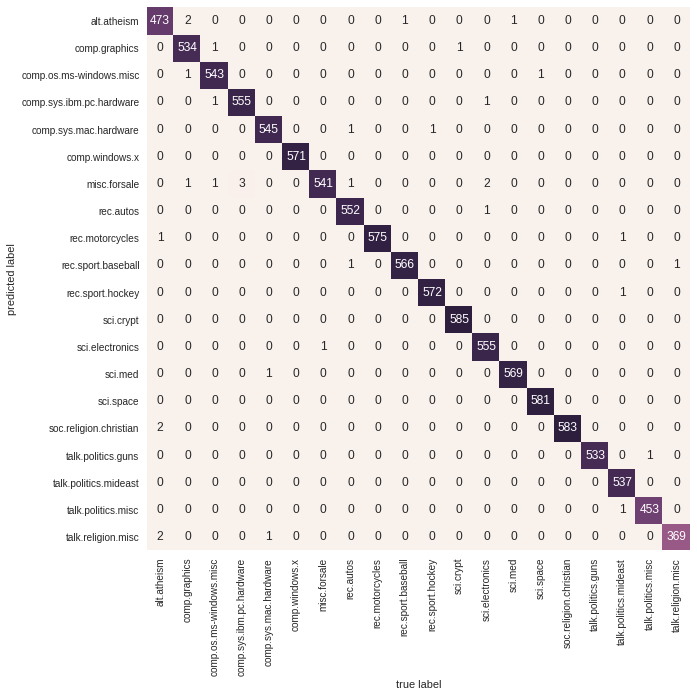

In [72]:
plt.figure(figsize=(10,10))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=newsgroups_train.target_names,yticklabels=newsgroups_train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()